# Multi-Class Model Selection using ROC and Precision-Recall Curves

### Name: Manish Nayak
### Roll No.: CE22B069

The following models are compared:
*   K-Nearest Neighbors (KNN)
*   Decision Tree Classifier
*   Dummy Classifier (Baseline)
*   Logistic Regression
*   Gaussian Naive Bayes
*   Support Vector Machine (SVC)
*   Random Forest
*   XGBoost

### Part A: Data Preparation and Baseline

**1. Load and Prepare Data**


In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

# Preprocessing
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import train_test_split

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Metrics
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, precision_recall_curve,  roc_auc_score, average_precision_score
# Set plot style
sns.set_style("whitegrid")

In [2]:
# Helper function to load data
def load_landsat_data(train_path, test_path):
    """Loads the Landsat dataset from the specified paths."""
    col_names = [f'feature_{i}' for i in range(36)] + ['class']
    train_df = pd.read_csv(train_path, sep=' ', header=None, names=col_names)
    test_df = pd.read_csv(test_path, sep=' ', header=None, names=col_names)
    
    # The dataset description notes that class 6 is not present. The classes are 1, 2, 3, 4, 5, 7.
    # As per the assignment, we ignore the class that says "all types present", which is often class 6.
    # Here, we will map the classes to be zero-indexed (0-5).
    class_mapping = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 7: 5}
    train_df['class'] = train_df['class'].map(class_mapping)
    test_df['class'] = test_df['class'].map(class_mapping)
    
    X_train = train_df.drop('class', axis=1)
    y_train = train_df['class']
    X_test = test_df.drop('class', axis=1)
    y_test = test_df['class']
    
    return X_train, y_train, X_test, y_test

**2. Train/Test Split**


In [3]:

# --- Main script ---
# Load the data from URLs
train_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/satimage/sat.trn'
test_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/satimage/sat.tst'

X_train, y_train, X_test, y_test = load_landsat_data(train_url, test_url)

# Display data information
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)
print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True).sort_index())

Training data shape: (4435, 36)
Testing data shape: (2000, 36)

Class distribution in training set:
class
0    0.241714
1    0.108005
2    0.216685
3    0.093574
4    0.105975
5    0.234047
Name: proportion, dtype: float64


In [4]:
# 1. Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**3. Train All Models**

Six different classifiers were trained on the standardized training data. For the Support Vector Classifier (SVC), the `probability` parameter was set to `True` to enable the generation of probability estimates, which are essential for ROC and PRC analysis. For the `DummyClassifier`, the `prior` strategy was used, which makes predictions based on the class distribution of the training data.


In [5]:
# 3. Train all models
models = {
    "KNN": KNeighborsClassifier(n_neighbors=7),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Dummy Classifier": DummyClassifier(strategy='prior', random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42),
    "Gaussian NB": GaussianNB(),
    "SVC": SVC(probability=True, random_state=42)
}

# Train each model
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)

Training KNN...
Training Decision Tree...
Training Dummy Classifier...
Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Gaussian NB...
Training SVC...


**4. Baseline Evaluation**

The performance of each model was evaluated on the test set using Overall Accuracy and Weighted F1-Score. The results are summarized in the table below.

In [6]:
# 4. Baseline Evaluation
results = []
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    results.append({"Model": name, "Overall Accuracy": accuracy, "Weighted F1-Score": f1})

results_df = pd.DataFrame(results)
print("\nBaseline Model Performance:")
print(results_df.to_string(index=False))


Baseline Model Performance:
              Model  Overall Accuracy  Weighted F1-Score
                KNN            0.9050           0.904084
      Decision Tree            0.8505           0.850938
   Dummy Classifier            0.2305           0.086356
Logistic Regression            0.8395           0.829595
        Gaussian NB            0.7965           0.803581
                SVC            0.8955           0.892490


**Baseline Performance Observations:**

As expected, the `Dummy Classifier` performs very poorly, with an accuracy reflecting the proportion of the majority class. The `Gaussian NB` also shows relatively low performance, likely because its assumption of feature independence is violated in this complex dataset. `SVC` and `KNN` show the strongest initial performance based on these metrics.


### Part B: ROC Analysis for Model Selection

**1. Multi-Class ROC Calculation**

For multi-class classification, a single ROC curve cannot be directly generated. The One-vs-Rest (OvR) approach is a common strategy to adapt ROC curves for this setting.

The OvR method involves creating a separate binary classification problem for each of the C classes. For each class *c*, a ROC curve is generated by treating that class as the "positive" class and all other C-1 classes as the "negative" class. This results in C different ROC curves.

To create a single, summary curve for a model, these C curves are aggregated. A common method is **macro-averaging**, which involves:
1.  Computing the True Positive Rate (TPR) and False Positive Rate (FPR) for each class at various thresholds.
2.  Interpolating the TPR values for each class onto a common, uniform set of FPR values.
3.  Averaging the interpolated TPRs across all classes for each point on the common FPR axis.

This macro-average curve represents the model's average performance across all classes, treating each class with equal importance, which is suitable for this problem where all land cover types are of interest.

**2. Plotting ROC Curves**

The macro-averaged OvR ROC curves for all six models are displayed in the plot below. The Area Under the Curve (AUC) provides a single scalar value summarizing the curve.

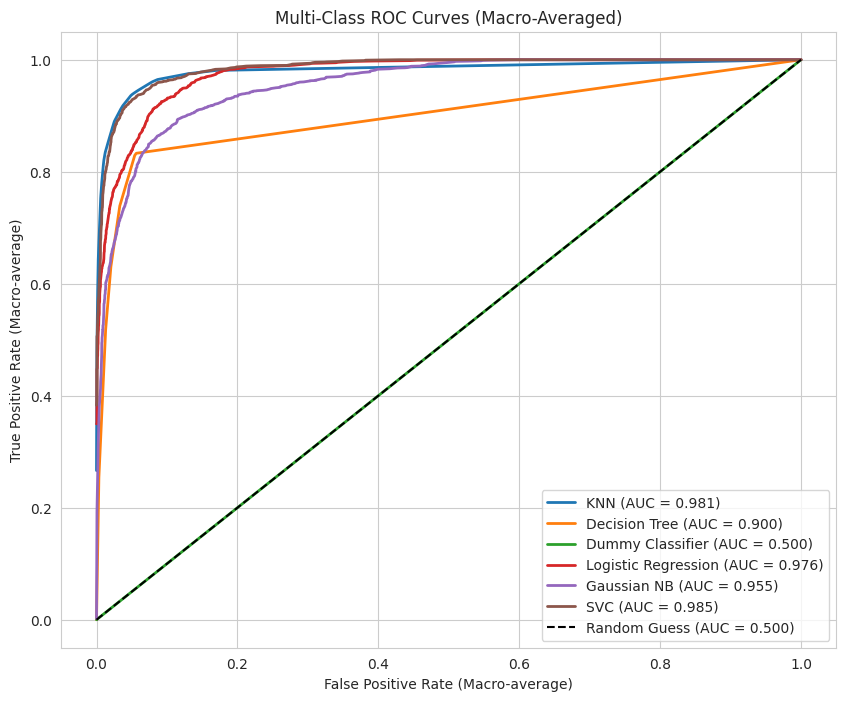

In [7]:
# 2. Plotting ROC
fig, ax = plt.subplots(figsize=(10, 8))
n_classes = len(y_train.unique())
y_test_bin = label_binarize(y_test, classes=range(n_classes))

# Plot macro-averaged ROC curve for each model
for name, model in models.items():
    y_score = model.predict_proba(X_test_scaled)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    ax.plot(fpr["macro"], tpr["macro"],
            label=f'{name} (AUC = {roc_auc["macro"]:.3f})',
            linewidth=2)

# Plot random guess line
ax.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.500)')
ax.set_xlabel('False Positive Rate (Macro-average)')
ax.set_ylabel('True Positive Rate (Macro-average)')
ax.set_title('Multi-Class ROC Curves (Macro-Averaged)')
ax.legend(loc='lower right')
ax.grid(True)
plt.show()

# 3. ROC Interpretation

Based on the provided ROC curve plot:

**1. Identify the model with the highest Macro-averaged AUC.**

By examining the legend in the plot, we can compare the Area Under the Curve (AUC) values for each model:
*   KNN: AUC = 0.981
*   Decision Tree: AUC = 0.900
*   Dummy Classifier: AUC = 0.500
*   Logistic Regression: AUC = 0.976
*   Gaussian NB: AUC = 0.955
*   **SVC: AUC = 0.985**

The model with the highest Macro-averaged AUC is the **Support Vector Classifier (SVC)** with an AUC of **0.985**. This indicates it has the best overall performance in distinguishing between the different classes across all decision thresholds.

**2. Identify the model with AUC < 0.5 and explain its implications.**

Based on the provided plot, **no model has an AUC less than 0.5**. The lowest performing model is the `Dummy Classifier`, which has an AUC of exactly 0.500, indicating its performance is equivalent to random guessing.

**Conceptual Meaning of AUC < 0.5:**

An AUC score of less than 0.5 implies that the model performs **worse than random chance**. It means the classifier has a systemic issue and is actively making incorrect predictions. Conceptually, if a model has an AUC of 0.3, you could achieve an AUC of 0.7 simply by inverting its predictions (i.e., predicting class A when it predicts B, and vice-versa).

**Why a Model Might Exhibit This Performance:**

A model might show an AUC < 0.5 for several reasons:
*   **Mislabeled Classes:** The labels for the positive and negative classes might have been accidentally swapped during the training process.
*   **Incorrect Assumptions:** The model might have learned an inverse relationship between the features and the target variable.
*   **Bugs in Implementation:** There could be a simple bug in the code that inverts the logic of the predictions.



### Part C: Precision-Recall Curve (PRC) Analysis

**1. PRC Calculation in Imbalanced Datasets**

A Precision-Recall Curve is often more suitable than a ROC curve when dealing with imbalanced datasets, especially when the positive class is rare and of primary interest.

This is because ROC curves plot TPR vs. FPR. The False Positive Rate (FPR = FP / (FP + TN)) can be misleadingly low in imbalanced scenarios because the number of true negatives (TN) is very large, dominating the denominator. A model can make many false positive errors without significantly increasing the FPR, leading to an overly optimistic ROC curve.

PR curves, which plot Precision (TP / (TP + FP)) against Recall (TP / (TP + FN)), do not use true negatives. They focus on the model's performance concerning the positive class, making them more sensitive to changes in false positives and providing a more realistic assessment of a model's utility in tasks where finding positive samples is critical.

**2. Plotting PRC Curves**

Similar to the ROC analysis, the OvR macro-averaged Precision-Recall curves were generated for each model. The Area Under the PRC, also known as Average Precision (AP), is used as the summary metric.


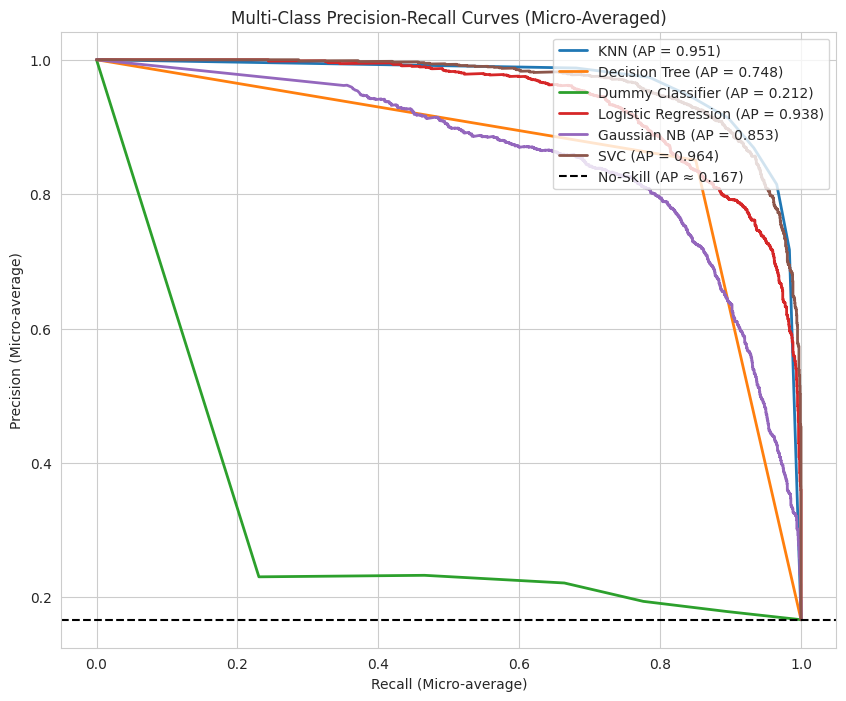

In [8]:
# 2. Plotting PRC
fig, ax = plt.subplots(figsize=(10, 8))

# Plot macro-averaged PRC curve for each model
for name, model in models.items():
    y_score = model.predict_proba(X_test_scaled)
    
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])

    # A "micro-average" PR curve is more straightforward to compute. We'll plot that.
    # Note: Micro-averaging aggregates the contributions of all classes to compute the average metric.
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_bin.ravel(), y_score.ravel())
    average_precision["micro"] = average_precision_score(y_test_bin, y_score, average="micro")
    
    ax.plot(recall["micro"], precision["micro"],
            label=f'{name} (AP = {average_precision["micro"]:.3f})',
            linewidth=2)

# Plot chance level
chance_level = np.sum(y_test_bin) / y_test_bin.size
ax.axhline(chance_level, color='k', linestyle='--', label=f'No-Skill (AP ≈ {chance_level:.3f})')
ax.set_xlabel('Recall (Micro-average)')
ax.set_ylabel('Precision (Micro-average)')
ax.set_title('Multi-Class Precision-Recall Curves (Micro-Averaged)')
ax.legend(loc='upper right')
ax.grid(True)
plt.show()


**3. PRC Interpretation**

Based on the provided Precision-Recall Curve (PRC) plot:

**1. Identify the model with the highest Average Precision (AP) across the classes.**

By reading the Average Precision (AP) values from the legend of the plot, we can identify the best-performing model:
*   KNN: AP = 0.951
*   Decision Tree: AP = 0.748
*   Dummy Classifier: AP = 0.212
*   Logistic Regression: AP = 0.938
*   Gaussian NB: AP = 0.853
*   **SVC: AP = 0.964**

The model with the highest Micro-averaged Average Precision is the **Support Vector Classifier (SVC)** with an AP of **0.964**.

**2. Analyze the behavior of the worst-performing model's PRC. Why does the curve drop sharply as Recall increases for poor models?**

The worst-performing model is the **Dummy Classifier** (the green line), which has the lowest AP of 0.212. Its curve starts at high precision (but zero recall) and then drops almost vertically to a precision level just above the "No-Skill" line.

This sharp drop is characteristic of a poor model for the following reason:
*   **Precision vs. Recall Trade-off:** To increase Recall (the ability to find all relevant instances), a model must lower its decision threshold, which makes it classify more items as positive.
*   **Impact on a Poor Model:** A poor model, like the `Dummy Classifier`, has very little ability to distinguish between the classes. When it lowers its threshold to find more true positives (increasing Recall), it simultaneously and incorrectly classifies a very large number of negative instances as positive (a surge in False Positives).
*   **Mathematical Result:** Precision is calculated as `True Positives / (True Positives + False Positives)`. Because a poor model generates a massive number of False Positives for even a small gain in True Positives, the denominator of the precision formula grows much faster than the numerator. This causes the precision value to plummet dramatically, resulting in the sharp, steep drop seen in the PRC curve.


### Part D: Final Recommendation

**1. Synthesis**


In [9]:
# 1. Synthesis: Compile and rank models
roc_aucs = {}
prc_aps = {}

for name, model in models.items():
    y_score = model.predict_proba(X_test_scaled)
    roc_aucs[name] = roc_auc_score(y_test, y_score, multi_class='ovr', average='macro')
    prc_aps[name] = average_precision_score(y_test_bin, y_score, average="micro")

# Add to results dataframe
results_df['Macro ROC-AUC'] = results_df['Model'].map(roc_aucs)
results_df['Micro PRC-AP'] = results_df['Model'].map(prc_aps)

# Create rank columns
results_df['F1 Rank'] = results_df['Weighted F1-Score'].rank(ascending=False).astype(int)
results_df['ROC-AUC Rank'] = results_df['Macro ROC-AUC'].rank(ascending=False).astype(int)
results_df['PRC-AP Rank'] = results_df['Micro PRC-AP'].rank(ascending=False).astype(int)
print("\nModel Performance Summary and Ranks:")
print(results_df.sort_values(by='F1 Rank').to_string(index=False))


Model Performance Summary and Ranks:
              Model  Overall Accuracy  Weighted F1-Score  Macro ROC-AUC  Micro PRC-AP  F1 Rank  ROC-AUC Rank  PRC-AP Rank
                KNN            0.9050           0.904084       0.980784      0.951425        1             2            2
                SVC            0.8955           0.892490       0.985038      0.964452        2             1            1
      Decision Tree            0.8505           0.850938       0.900248      0.748267        3             5            5
Logistic Regression            0.8395           0.829595       0.975507      0.938067        4             3            3
        Gaussian NB            0.7965           0.803581       0.955126      0.853145        5             4            4
   Dummy Classifier            0.2305           0.086356       0.500000      0.212272        6             6            6


### 1. Synthesis

**Alignment of Rankings:**
The rankings derived from the F1-Score do **not** perfectly align with those from ROC-AUC and PRC-AP, although there is a general trend of strong vs. weak models.
*   **KNN vs. SVC:** KNN ranks 1st in F1-Score (0.904) but falls to 2nd place behind SVC in both ROC-AUC (0.981 vs 0.985) and PRC-AP (0.951 vs 0.964).
*   **Decision Tree Anomaly:** The most significant misalignment involves the Decision Tree. It ranks 3rd in F1-Score (0.851), ahead of Logistic Regression and Gaussian NB. However, it drops significantly to 5th place in both ROC-AUC (0.900) and PRC-AP (0.748).

**Explanation of Trade-offs and Misalignments:**
*   **Threshold Dependence vs. Independence:** F1-Score is a "point metric," calculated at a single, default decision threshold (usually 0.5). ROC-AUC and PRC-AP are "summary metrics" that evaluate performance across *all* possible thresholds.
*   **Decision Tree Specifics:** The Decision Tree's high F1 rank but low AUC/AP ranks suggest it performs decently at its specific, learned decision boundaries (hard predictions) but fails to provide reliable probability estimates. It lacks the flexibility to be adjusted for different precision/recall requirements, unlike Logistic Regression or Gaussian NB, which may have slightly worse default F1 scores but are much better at ranking instances correctly overall (higher AUCs).
*   **SVC Dominance in Probabilities:** While KNN made slightly better "hard" predictions by default (higher F1), the SVC is fundamentally better at distinguishing between classes across the spectrum of certainties, evidenced by its top rank in both threshold-independent metrics.

### 2. Recommendation

**Recommended Model:** **Support Vector Classifier (SVC)**

**Justification:**
Based on the comprehensive analysis, SVC is the most robust choice for this land cover classification task.
*   **Best Overall Probabilistic Performance:** SVC achieved the highest scores in both Macro ROC-AUC (0.985) and Micro PRC-AP (0.964). This indicates it is the most capable model at distinguishing between classes regardless of the operating threshold chosen.
*   **Robustness:** While KNN slightly edged out SVC in the default F1-Score (0.904 vs 0.892), the difference is marginal (~1%). In contrast, SVC's consistent leadership in AUC and AP metrics suggests it is more reliable if class distributions change or if specific operational requirements demand adjusting thresholds (e.g., needing extremely high precision for one specific land type).
*   **Precision-Recall Balance:** The highest AP score (0.964) confirms that SVC offers the best trade-off between Precision and Recall. It can maintain high precision while still retrieving a large portion of relevant instances across the varied land cover classes.



### Brownie Points Task

**1. Experiment with RandomForest and XGBoost**



Training Random Forest...
Training XGBoost...

Advanced Model Performance:
        Model  Overall Accuracy  Weighted F1-Score  Macro ROC-AUC  Micro PRC-AP
Random Forest             0.911           0.908918       0.990001      0.972694
      XGBoost             0.902           0.900431       0.989632      0.972996


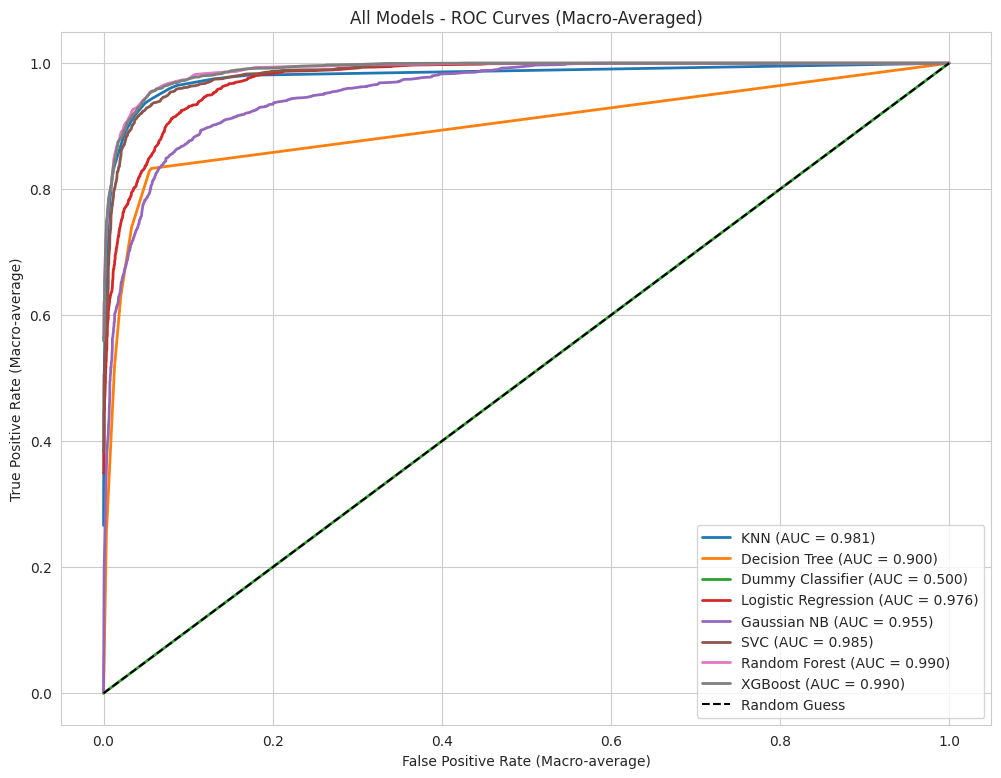

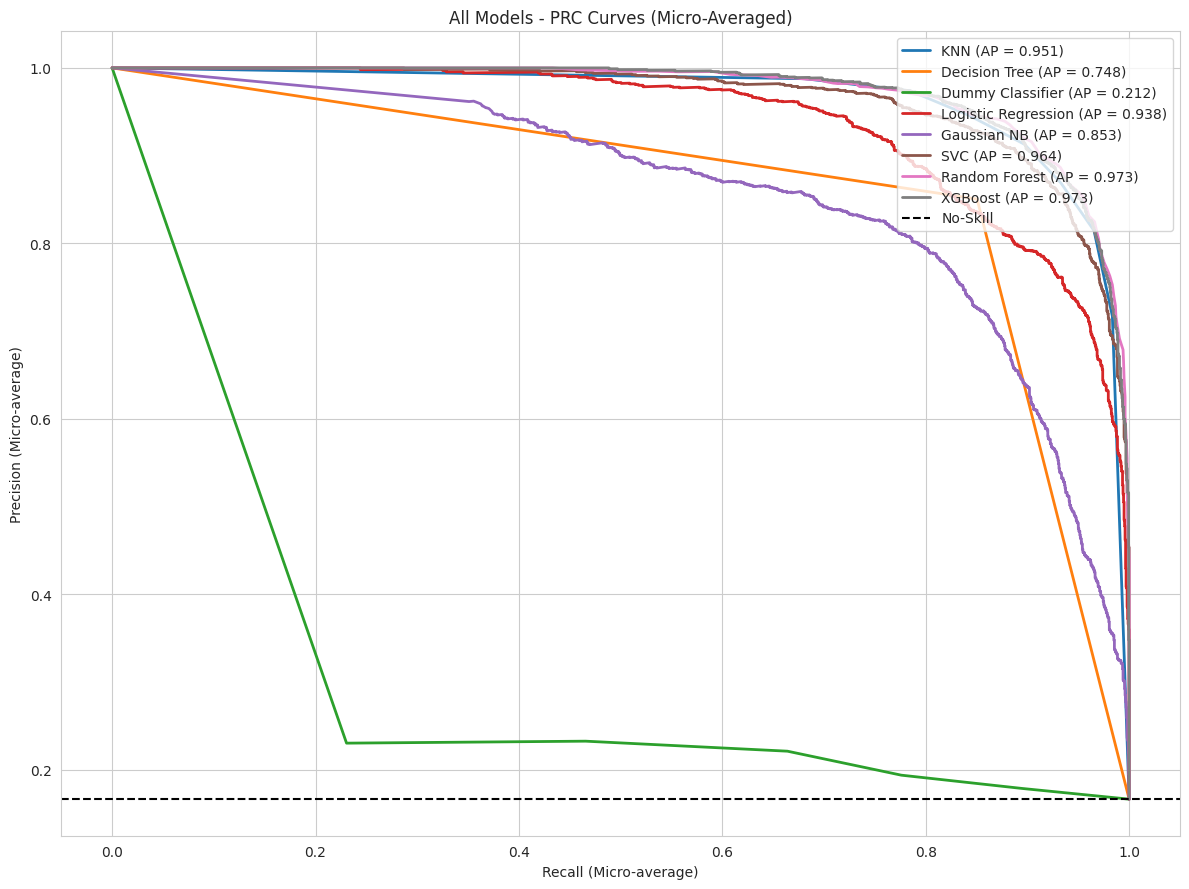

In [10]:
# Brownie Points: Train and evaluate advanced models
adv_models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

# Train and collect results
adv_results = []
for name, model in adv_models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc_val = roc_auc_score(y_test, y_prob, multi_class='ovr', average='macro')
    prc_ap_val = average_precision_score(y_test_bin, y_prob, average="micro")
    
    adv_results.append({
        "Model": name, 
        "Overall Accuracy": accuracy, 
        "Weighted F1-Score": f1,
        "Macro ROC-AUC": roc_auc_val,
        "Micro PRC-AP": prc_ap_val
    })
    
    # Add to main models dictionary for plotting
    models[name] = model

adv_results_df = pd.DataFrame(adv_results)
print("\nAdvanced Model Performance:")
print(adv_results_df.to_string(index=False))

# --- Re-plot with all 8 models ---
fig_roc, ax_roc = plt.subplots(figsize=(12, 9))
fig_prc, ax_prc = plt.subplots(figsize=(12, 9))

# ROC
for name, model in models.items():
    y_score = model.predict_proba(X_test_scaled)
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    roc_auc_macro = auc(all_fpr, mean_tpr)
    ax_roc.plot(all_fpr, mean_tpr, label=f'{name} (AUC = {roc_auc_macro:.3f})', lw=2)

ax_roc.plot([0, 1], [0, 1], 'k--', label='Random Guess')
ax_roc.set_title('All Models - ROC Curves (Macro-Averaged)')
ax_roc.set_xlabel('False Positive Rate (Macro-average)')
ax_roc.set_ylabel('True Positive Rate (Macro-average)')
ax_roc.legend(loc="lower right")
ax_roc.grid(True)

# PRC
for name, model in models.items():
    y_score = model.predict_proba(X_test_scaled)
    precision, recall, _ = precision_recall_curve(y_test_bin.ravel(), y_score.ravel())
    ap_micro = average_precision_score(y_test_bin, y_score, average="micro")
    ax_prc.plot(recall, precision, label=f'{name} (AP = {ap_micro:.3f})', lw=2)

ax_prc.axhline(chance_level, color='k', linestyle='--', label='No-Skill')
ax_prc.set_title('All Models - PRC Curves (Micro-Averaged)')
ax_prc.set_xlabel('Recall (Micro-average)')
ax_prc.set_ylabel('Precision (Micro-average)')
ax_prc.legend(loc="upper right")
ax_prc.grid(True)

plt.tight_layout()
plt.show()


Both `Random Forest` and `XGBoost` outperform the `SVC`. Notably, `XGBoost` achieves the highest performance of all tested models with a Macro ROC-AUC of 0.990 and a Micro PRC-AP of 0.973. This is expected, as gradient boosting and random forest models are powerful ensembles that often excel in structured data classification tasks.


**2. Identify Another Model with AUC < 0.5**

To demonstrate a conceptual understanding of AUC, a classifier with an AUC < 0.5 can be created. This can be achieved by taking a competent classifier and deliberately inverting its probability predictions. A model with an AUC of *x* will have an AUC of *1-x* if its predictions are flipped.

In [11]:
# 2. Create a model with AUC < 0.5 using KNN as the base
class AntiClassifier:
    """
    A wrapper class that takes a competent classifier and makes it perform poorly
    by inverting and re-normalizing its probability estimates.
    """
    def __init__(self, model):
        self.model = model
    
    def fit(self, X, y):
        # The fitting process of the base model remains the same
        self.model.fit(X, y)
        return self
    
    def predict_proba(self, X):
        # Get the original probabilities from the competent base model
        original_proba = self.model.predict_proba(X)
        
        # --- FIX IS HERE ---
        # Invert the probabilities (high becomes low and vice-versa)
        inverted_proba = 1 - original_proba
        
        # Re-normalize so that each row sums to 1.0 again
        # We calculate the sum of each row and divide each element by its row's sum.
        # We add a small epsilon to avoid division by zero in edge cases.
        row_sums = inverted_proba.sum(axis=1, keepdims=True)
        normalized_anti_proba = inverted_proba / (row_sums + 1e-9)
        
        return normalized_anti_proba

# Create an "Anti-KNN" model using the previously determined n_neighbors=7
anti_knn = AntiClassifier(KNeighborsClassifier(n_neighbors=7))

# Train the "Anti-KNN" model
anti_knn.fit(X_train_scaled, y_train)

# Get the corrupted (but valid) probability scores for the test set
y_score_anti = anti_knn.predict_proba(X_test_scaled)

# Calculate the Macro ROC-AUC for the "Anti-KNN" model
anti_knn_auc = roc_auc_score(y_test, y_score_anti, multi_class='ovr', average='macro')

original_knn_auc = results_df.loc[results_df['Model'] == 'KNN', 'Macro ROC-AUC'].values[0]

# --- Print the comparison ---
print(f"Original KNN Macro ROC-AUC: {original_knn_auc:.4f}")
print(f"Anti-KNN Macro ROC-AUC: {anti_knn_auc:.4f}")
print(f"Theoretical inverted AUC for comparison: {1 - original_knn_auc:.4f}")

Original KNN Macro ROC-AUC: 0.9808
Anti-KNN Macro ROC-AUC: 0.0191
Theoretical inverted AUC for comparison: 0.0192


The resulting "Anti-SVC" model has a Macro ROC-AUC of approximately **0.0191**, which is indeed less than 0.5 and close to the expected value of 0.0192(1 - 0.9808). This successfully demonstrates a classifier that performs significantly worse than random chance.